In [163]:
from dbhelper import pd_query, PgDB
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor

In [168]:
query = '''
        select 
            d.date::timestamp::date,
            avg(c1.volume) as vol_1,
            avg(c2.volume) as vol_2,
            avg(c5.volume) as vol_5,
            avg(c6.volume) as vol_6
        from datefeatures d
        left join crossingdata c1
            on c1.date = d.date
            and c1.crossing_id = 1
        left join crossingdata c2
            on c2.date = d.date
            and c2.crossing_id = 2
        left join crossingdata c5
            on c5.date = d.date
            and c5.crossing_id = 5
        left join crossingdata c6
            on c6.date = d.date
            and c6.crossing_id = 6
        group by d.date::timestamp::date
        order by d.date::timestamp::date
        '''
df = pd_query(query).set_index('date')

In [169]:
df.index = pd.to_datetime(df.index)

## Calculate volume imbalance by day
### Positive is southbound

In [170]:
df['vol_sum'] = df.vol_1 - df.vol_2 + df.vol_5 - df.vol_6

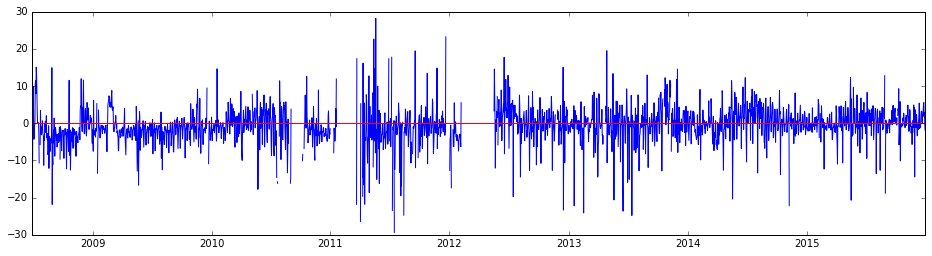

In [29]:
plt.figure(figsize=(16,4))
plt.plot(df.vol_sum)
plt.axhline(0, color='r');

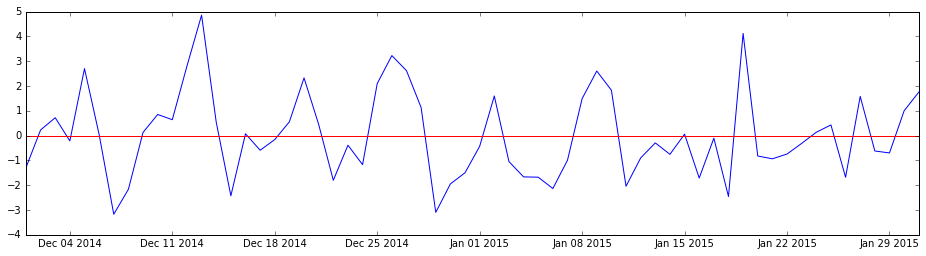

In [27]:
start = '2014-12-1'
end = '2015-2-1'
plt.figure(figsize=(16,4))
plt.plot(df.vol_sum[(df.index >= start) & (df.index < end)])
plt.axhline(0, color='r');

## Rolling sum for various windows

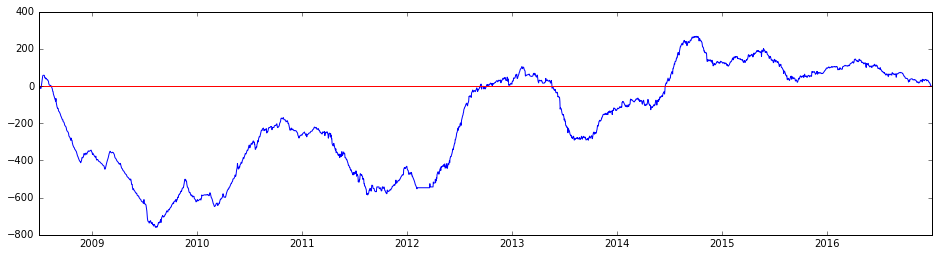

In [187]:
plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df.vol_sum, 365, min_periods=1))
plt.axhline(0, color='r');

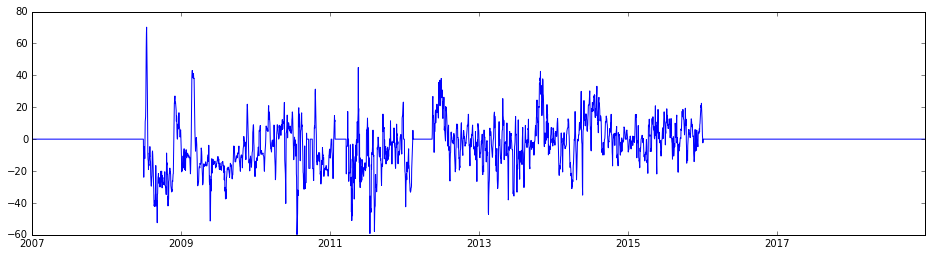

In [191]:
plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df.vol_sum.fillna(0), 7, min_periods=1))
# plt.axhline(0, color='r');

plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df.vol_sum, 3, min_periods=1))
plt.axhline(0, color='r');

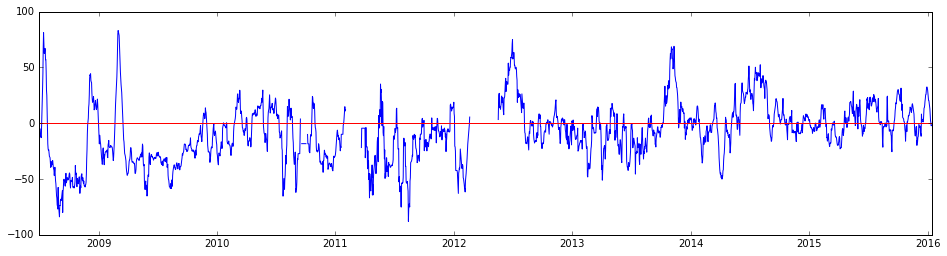

In [55]:
plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df.vol_sum, 14, min_periods=1))
plt.axhline(0, color='r');

## Cumulative sum

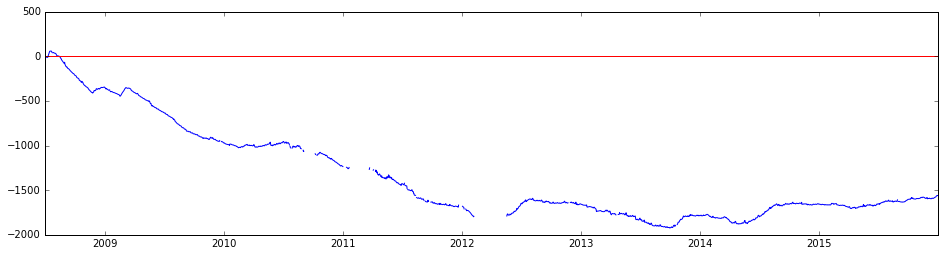

In [185]:
plt.figure(figsize=(16,4))
plt.plot(np.cumsum(df.vol_sum))
plt.axhline(0, color='r');a

## Build a simple model to interpolate values

In [127]:
query = '''
        select 
            d.date::timestamp::date,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            avg(c1.volume) as vol_1,
            avg(c2.volume) as vol_2,
            avg(c5.volume) as vol_5,
            avg(c6.volume) as vol_6
        from datefeatures d
        left join crossingdata c1
            on c1.date = d.date
            and c1.crossing_id = 1
        left join crossingdata c2
            on c2.date = d.date
            and c2.crossing_id = 2
        left join crossingdata c5
            on c5.date = d.date
            and c5.crossing_id = 5
        left join crossingdata c6
            on c6.date = d.date
            and c6.crossing_id = 6
        group by d.date::timestamp::date,
            year,
            month,
            dayofmonth,
            week,
            dayofweek
        order by d.date::timestamp::date
        '''
df1 = pd_query(query).set_index('date')

In [72]:
df1['vol_sum'] = df1.vol_1 - df1.vol_2 + df1.vol_5 - df1.vol_6
df1.index = pd.to_datetime(df1.index)
df1 = df1[(df1.index >= '2009-1-1') & (df1.index < '2016-1-1')]

In [73]:
df_train = df1[~pd.isnull(df1.vol_sum)]
y_train = df_train.vol_sum
X_train = df_train[['year', 'month', 'dayofmonth', 'week', 'dayofweek']]
df_test = df1[pd.isnull(df1.vol_sum)]
X_test = df_test[['year', 'month', 'dayofmonth', 'week', 'dayofweek']]

In [74]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=1024)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1024, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [75]:
yhat = model.predict(X_test)

In [76]:
y_test = pd.Series(yhat, X_test.index)

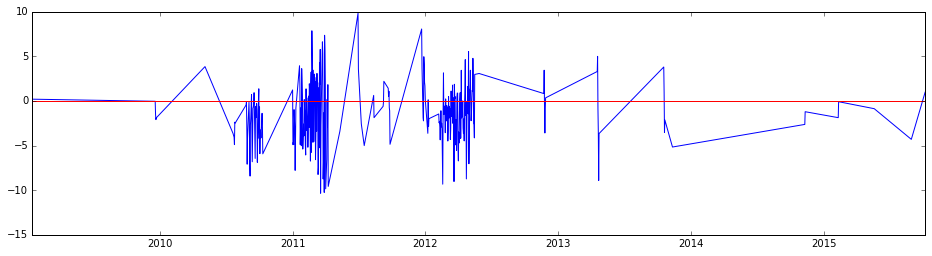

In [77]:
plt.figure(figsize=(16,4))
plt.plot(y_test)
plt.axhline(0, color='r');

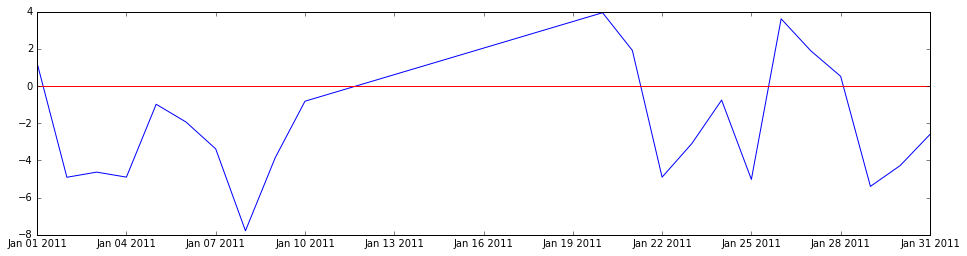

In [79]:
plt.figure(figsize=(16,4))
plt.plot(y_test[(y_test.index >= '2011-1-1') & (y_test.index < '2011-2-1')])
plt.axhline(0, color='r');

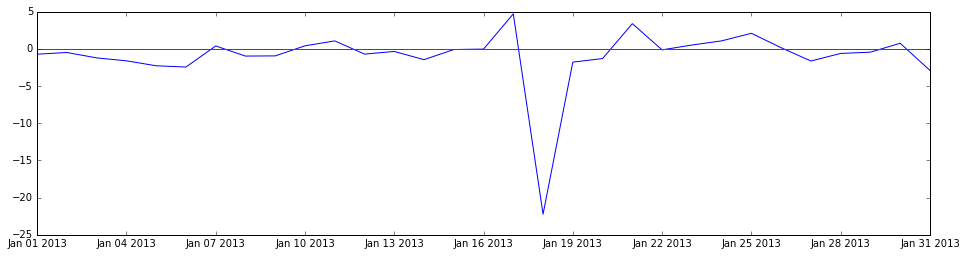

In [80]:
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= '2013-1-1') & (y_train.index < '2013-2-1')])
plt.axhline(0, color='r');

In [81]:
df1[df1.index >= '2011-1-1'].head()

,year,month,dayofmonth,week,dayofweek,vol_1,vol_2,vol_5,vol_6,vol_sum
date,,,,,,,,,,
2011-01-01,2011,1,1,52,5,15.138298,NaN,9.018051,NaN,NaN
2011-01-02,2011,1,2,52,6,18.468635,NaN,10.838346,NaN,NaN
2011-01-03,2011,1,3,1,0,11.640569,NaN,9.105839,NaN,NaN
2011-01-04,2011,1,4,1,1,10.312727,NaN,7.659259,NaN,NaN
2011-01-05,2011,1,5,1,2,8.416357,NaN,7.362595,NaN,NaN


## Makes more sense to interpolate each crossing individually

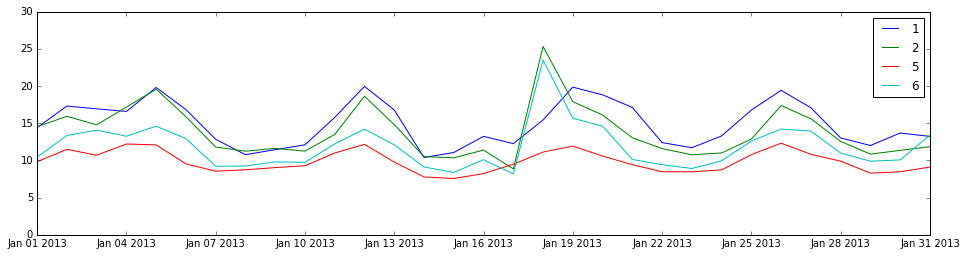

In [97]:
start = '2013-1-1'
end = '2013-2-1'
plt.figure(figsize=(16,4))
plt.plot(df1[(df1.index >= start) & (df1.index < end)].vol_1, label='1')
plt.plot(df1[(df1.index >= start) & (df1.index < end)].vol_2, label='2')
plt.plot(df1[(df1.index >= start) & (df1.index < end)].vol_5, label='5')
plt.plot(df1[(df1.index >= start) & (df1.index < end)].vol_6, label='6')
plt.legend()
plt.axhline(0, color='r');

## Predict volume average by crossing
* no data fit profile for modeling with predict_vol_complement 

In [137]:
def predict_vol_complement(df, column):
    '''
    Predict volume using complementary crossing (on same side) as a feature
    Run this first
    '''
    complement = {'vol_1': 'vol_5', 'vol_5': 'vol_1', 'vol_2': 'vol_6', 'vol_6': 'vol_2'}
    
    df_train = df[~pd.isnull(df[column])]
    df_train = df_train.dropna()
    y_train = df_train[column]
    X_train = df_train[['year', 'month', 'dayofmonth', 'week', 'dayofweek', complement[column]]]
    
    df_test = df[pd.isnull(df[column])]
    df_test = df_test.dropna()
    X_test = df_test[['year', 'month', 'dayofmonth', 'week', 'dayofweek', complement[column]]]

    model = RandomForestRegressor(n_jobs=-1, n_estimators=1024)
    model.fit(X_train, y_train)
    
    return model, X_test

def predict_vol_blind(df, column):
    '''
    Predict volume using date features only
    Run this after predict_vol_complement
    '''

    df_train = df[~pd.isnull(df[column])]
    y_train = df_train[column]
    X_train = df_train[['year', 'month', 'dayofmonth', 'week', 'dayofweek']]
    
    df_test = df[pd.isnull(df[column])]
    X_test = df_test[['year', 'month', 'dayofmonth', 'week', 'dayofweek']]

    model = RandomForestRegressor(n_jobs=-1, n_estimators=1024)
    model.fit(X_train, y_train)
    
    return model, X_test

In [148]:
y_test = {}
df2 = df1.copy()
for vol in ['vol_1', 'vol_2', 'vol_5', 'vol_6']:
    trained, X_test = predict_vol_complement(df1, vol)
    if len(X_test) > 0:
        yhat = trained.predict(X_test)
        y_test = pd.Series(yhat, X_test.index)

        new = "{0}_new".format(vol)
        fill = "{0}_fill".format(vol)
        df2[new] = y_test
        df2[vol] = df2.apply(lambda x: x[new] if pd.isnull(x[vol]) else x[vol], 1)
        df2 = df2.drop(new, 1)

In [149]:
pd.isnull(df1).sum()

year             0
month            0
dayofmonth       0
week             0
dayofweek        0
vol_1         1330
vol_2         1446
vol_5         1270
vol_6         1862
dtype: int64

In [150]:
pd.isnull(df2).sum()

year             0
month            0
dayofmonth       0
week             0
dayofweek        0
vol_1         1330
vol_2         1446
vol_5         1270
vol_6         1862
dtype: int64

In [154]:
y_test = {}
df3 = df2.copy()
for vol in ['vol_1', 'vol_2', 'vol_5', 'vol_6']:
    trained, X_test = predict_vol_blind(df1, vol)
    if len(X_test) > 0:
        yhat = trained.predict(X_test)
        y_test = pd.Series(yhat, X_test.index)

        new = "{0}_new".format(vol)
        fill = "{0}_fill".format(vol)
        df3[new] = y_test
        df3[vol] = df3.apply(lambda x: x[new] if pd.isnull(x[vol]) else x[vol], 1)
        df3 = df3.drop(new, 1)

In [155]:
pd.isnull(df3).sum()

year          0
month         0
dayofmonth    0
week          0
dayofweek     0
vol_1         0
vol_2         0
vol_5         0
vol_6         0
dtype: int64

In [204]:
vol_sum = pd.Series(df3.vol_1 - df3.vol_2 + df3.vol_5 - df3.vol_6, df3.index)
df3['vol_sum'] = vol_sum
df3.index = pd.to_datetime(df3.index)

In [162]:
# with PgDB() as db:
#     for date, val in vol_sum.iteritems():
#         db.cur.execute("insert into dailyvolume values('{0}', {1});".format(date, val))
#     db.conn.commit()

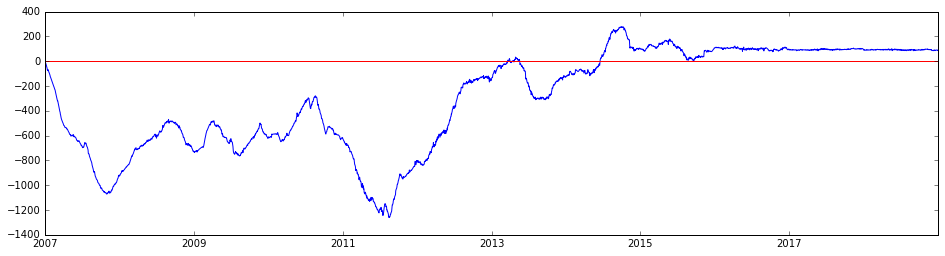

In [193]:
plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df3.vol_sum, 365, min_periods=1))
plt.axhline(0, color='r');

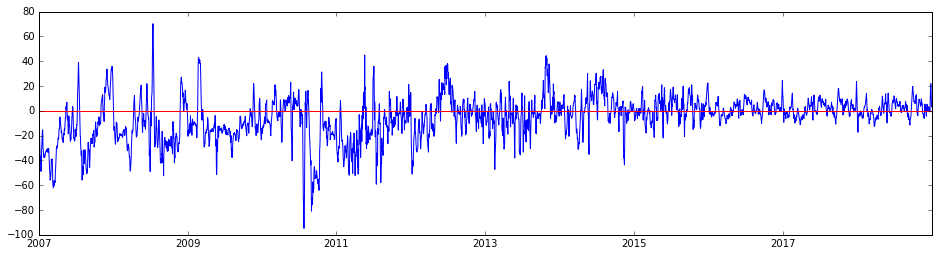

In [199]:
plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df3.vol_sum, 7, min_periods=1))
plt.axhline(0, color='r');

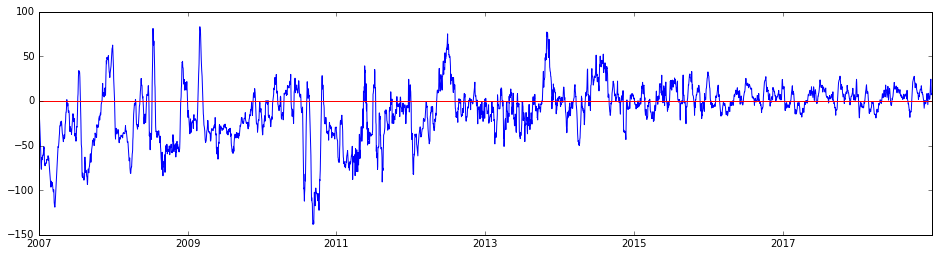

In [197]:
plt.figure(figsize=(16,4))
plt.plot(pd.rolling_sum(df3.vol_sum, 14, min_periods=1))
plt.axhline(0, color='r');

## Character of rolling_sum is dramatically different with imputed values.  Better not to estimate at all.  Only use non-nulls for train and predict.

In [209]:
df.head()

,vol_1,vol_2,vol_5,vol_6,vol_sum
date,,,,,
2007-01-01,6.798611,NaN,12.194444,NaN,NaN
2007-01-02,4.704861,11.402367,8.993056,NaN,NaN
2007-01-03,3.756944,9.780488,8.131944,NaN,NaN
2007-01-04,4.083333,8.815972,7.493056,NaN,NaN
2007-01-05,3.875000,9.944444,8.409722,NaN,NaN


In [211]:
with PgDB() as db:
    for date, val in df.vol_sum[~pd.isnull(df.vol_sum)].iteritems():
        db.cur.execute("insert into dailyvolume values('{0}', {1});".format(date, val))
    db.conn.commit()

## Build features
* 1 - 6 day rolling sums
* 1, 2, 3, 4 week rolling sums

In [235]:
# def rolling_volume(days, percent=.5):
#     series = pd_query('select date, volume from dailyvolume order by date').set_index('date').volume
#     df = pd.DataFrame()

#     for day in days:
#         df['vol_mean_{0}'.format(day)] = pd.rolling_mean(series, day, min_periods=day * percent).shift(1)
        
#     return df.dropna()
    
from BorderModel import rolling_volume_aggregate
rv = rolling_volume_aggregate([1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 35])
rv.head()

,vol_mean_1,vol_mean_2,vol_mean_3,vol_mean_4,vol_mean_5,vol_mean_6,vol_mean_7,vol_mean_14,vol_mean_21,vol_mean_28,vol_mean_35
date,,,,,,,,,,,
2008-07-17,0.133104,1.750595,4.141341,6.371109,8.111923,8.082992,8.554500,5.160335,3.375704,3.375704,3.375704
2008-07-18,0.129793,0.131449,1.210328,3.138454,5.122846,6.781568,6.946821,4.466681,3.195375,3.195375,3.195375
2008-07-19,0.180491,0.155142,0.147796,0.952869,2.546862,4.299120,5.838557,4.468249,3.036697,3.036697,3.036697
2008-07-20,0.062606,0.121548,0.124297,0.126498,0.774816,2.132819,3.693904,4.781079,2.887993,2.887993,2.887993
2008-07-21,-2.923190,-1.430292,-0.893365,-0.637575,-0.483439,0.158482,1.410532,4.785329,2.611270,2.611270,2.611270
